<h1 style="text-align: center; color: #027BFF; font-size: 2em;">
    📘🧠 Create a <span style="color: #DD7394;">Multi Layer Precepteron</span> from Scratch 🤖🦾
</h1>

### Table of Contents
1. [Create a Fake Dataset](#create-a-fake-dataset)
2. [Data Normalization](#data-normalization)
3. [Forward Propegation](#forward-propegation)
4. [Modular Forward Propegation Function](#modular-forward-propegation-function)
5. [Calcualting Loss](#calcualting-loss)
6. [Backpropegation](#backpropegation)

In [1]:
# for implementation
import numpy as np

# for testing
import tensorflow as tf

# other imports i might need
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
backend_inline.set_matplotlib_formats('retina')

# Create a Fake Dataset
returns X and y which are related to each other by weights matrixs

In [15]:
def dummy_data(examples, features):
    X = np.random.randint(10, size=(examples, features))
    weights = np.random.randint(10, size=(features, 1))
    y = np.dot(X, weights)
    return X, y

In [16]:
examples = 20
features = 3
X, y = dummy_data(examples, features)
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

X.shape: (20, 3), y.shape: (20, 1)


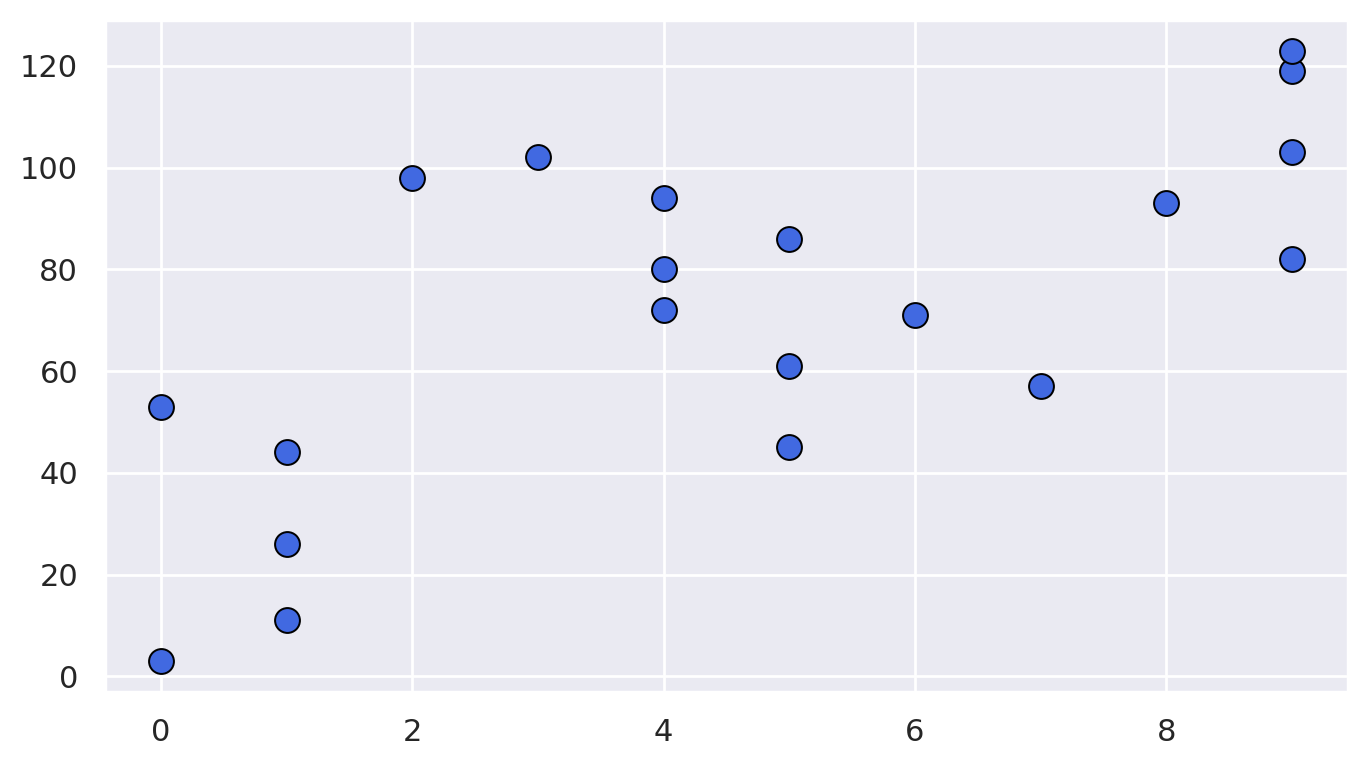

In [17]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")

sns.scatterplot(x=X[:, 0], y=y.reshape(-1), s=80, color='royalblue', edgecolor='black')

plt.tight_layout()
plt.show()

# Data Normalization  <a id="data-normalization"></a>
* scale values to have a mean of 0 and std of 1

In [18]:
# Data Standardization
# (feature - feature.mean) / std(feature) for feature in X
def z_score_normalization(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [19]:
X = z_score_normalization(X)
y = z_score_normalization(y)

# check std (should be 1.)
np.std(X, axis=0), np.std(y, axis=0)

(array([1., 1., 1.]), array([1.]))

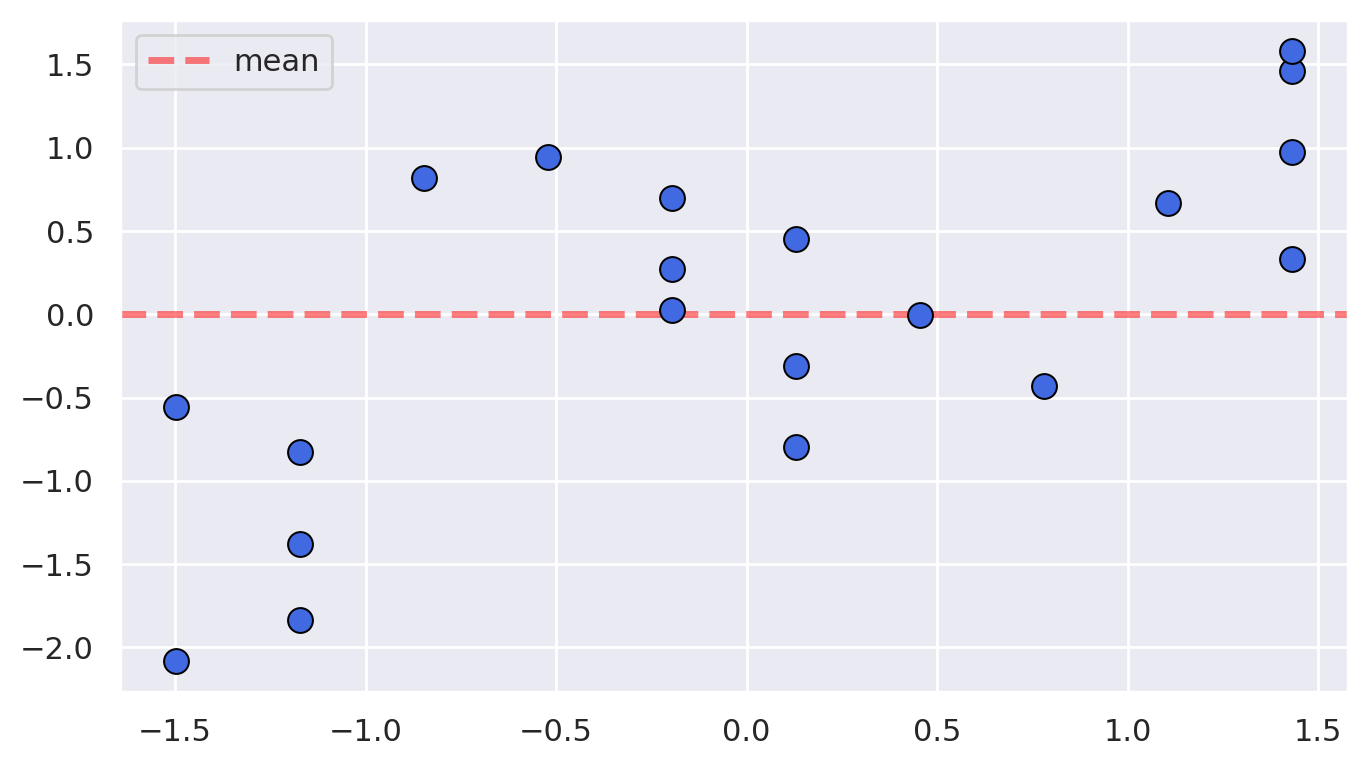

In [20]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")

plt.axhline(0, color='red', linestyle='--', linewidth=2.5, alpha=0.5, label='mean', zorder=1)
sns.scatterplot(x=X[:, 0], y=y.reshape(-1), s=80, color='royalblue', edgecolor='black', zorder=2)

plt.tight_layout()
plt.legend()
plt.show()

# Forward Propegation <a id="forward-propegation"></a>
* a single neuron have $n$ weights where n is the number of features in the input $(features, 1)$
* each layer have an arbitrary amount of neurons so each layers dimentions are $(features, neurons)$
___
#### **Example of Typical Calculations for Forward Prop**
*Demo Network Flow*:  
`Input (1024, 3) → Dense(512) → Dense(256) → Dense(128) → Output(1)`

In [21]:
# dummy data
examples = 1024
features = 3
input_data = np.random.randint(10, size=(examples, features))

# create weights and biases
w_0, b_0 = np.random.randint(10, size=(features, 512)), np.random.randint(10, size=(512,))
w_1, b_1 = np.random.randint(10, size=(512, 256)), np.random.randint(10, size=(256,))
w_2, b_2 = np.random.randint(10, size=(256, 128)), np.random.randint(10, size=(128,))
w_3, b_3 = np.random.randint(10, size=(128, 1)), np.random.randint(10, size=(1,))

# propegate on weights and biases
a_0 = np.dot(input_data, w_0) + b_0
a_1 = np.dot(a_0, w_1) + b_1
a_2 = np.dot(a_1, w_2) + b_2
a_3 = np.dot(a_2, w_3) + b_3

In [22]:
# check dimentions
print(f'{input_data.shape} -> {a_0.shape} -> {a_1.shape} -> {a_2.shape} -> {a_3.shape}')

(1024, 3) -> (1024, 512) -> (1024, 256) -> (1024, 128) -> (1024, 1)


## Modular Forward Propegation Function <a id="modular-forward-propegation-function"></a>
* when going deeper in a neural networks layers the dimentions aren't simply **examples, features** so in deeper layers we change the notation to **(input_dims, output_dims)** this transition happns in the first layer and from that point on, each subsequent layer receives input of shape **(examples, input_dims)** and transforms it into **(examples, output_dims)** using a weight matrix of shape **(input_dims, output_dims)**.

In [23]:
class DenseLayer:
    def __init__(self, output_dims):
        self.output_dims = output_dims
        self.W = None
        self.b = None
        self.A = None
        self.A_prev = None

    def __initialize_params(self, input_dims):
        self.W = np.random.randn(input_dims, self.output_dims)
        self.b = np.zeros(self.output_dims,)

    def propagate(self, A_prev):
        self.A_prev = A_prev

        if self.W is None:
            self.input_dims = self.A_prev.shape[1]
            self.__initialize_params(self.input_dims)

        self.A = np.dot(self.A_prev, self.W) + self.b
        return self.A

In [24]:
def forwards(X, layers):
    A = X
    for layer in layers:
        A = layer.propagate(A)
    return A

In [25]:
layers = [
    DenseLayer(10),
    DenseLayer(5),
    DenseLayer(1)
]

In [26]:
y_pred = forwards(X, layers)

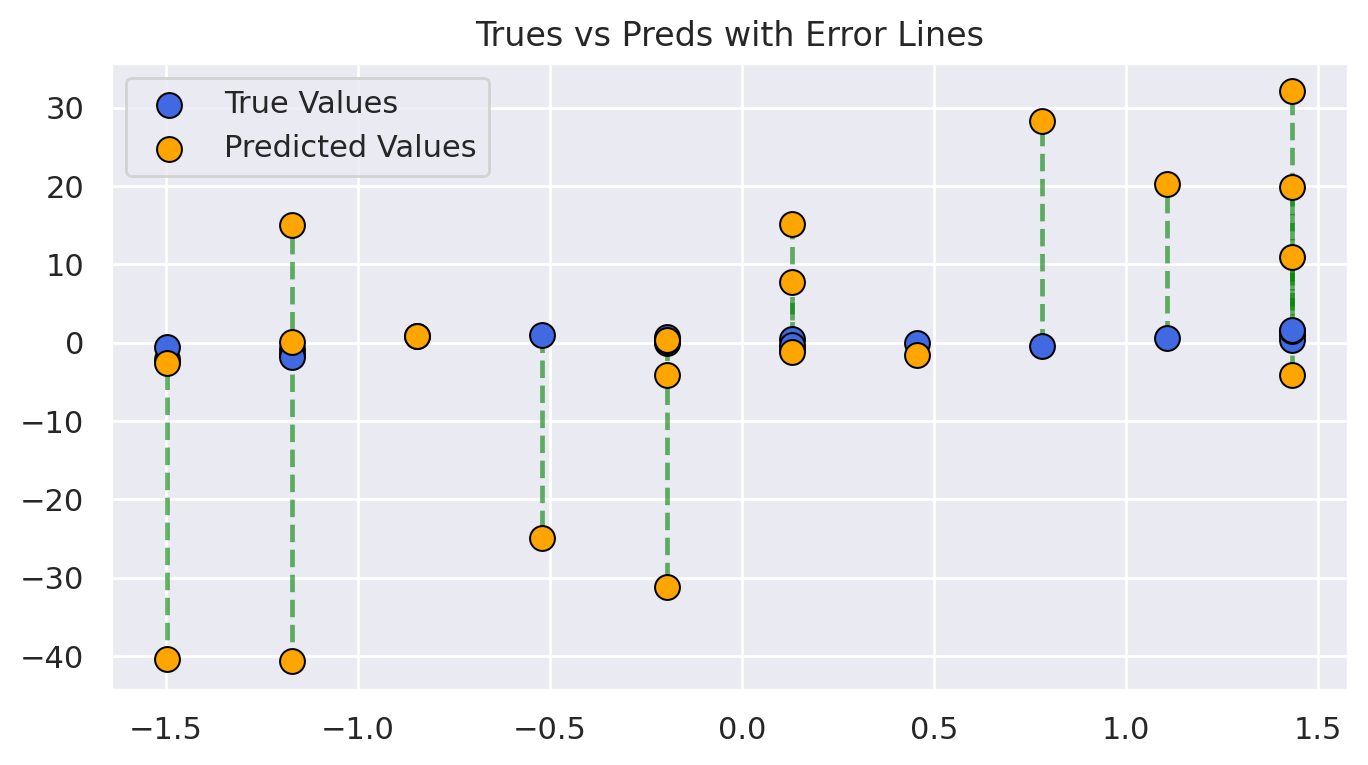

In [27]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")

for x_point, y_point, pred_point in zip(X[:, 0], y.reshape(-1), y_pred.reshape(-1)):
  plt.plot([x_point, x_point], [y_point, pred_point], color='green', linestyle='--', linewidth=1.7, alpha=0.6, zorder=1)

sns.scatterplot(x=X[:, 0], y=y.reshape(-1), s=80, color='royalblue', edgecolor='black', label='True Values', zorder=2)
sns.scatterplot(x=X[:, 0], y=y_pred.reshape(-1), s=80, color='orange', edgecolor='black', label='Predicted Values', zorder=2)

plt.title("Trues vs Preds with Error Lines")
plt.legend()
plt.tight_layout()
plt.show()

# Calcualting Loss <a id="calcualting-loss"></a>
* the function that will be used to evaluate the networks fit is called mean squared erorr and calculates the average of the squared distances between the real and the predicted data
* Formula: $\displaystyle J(\theta)=\frac{1}{2m}\sum_{i=1}^{m}(y_i - \hat{y}_i)^2$

In [28]:
# sum of the squared risiduales = sum(np.pow((y_true - y_pred), 2))
# m = len(y_true)
# add *2 to m for easier derivative calculation

def mean_squared_error(y_true, y_pred):
    return sum(np.pow((y_true - y_pred), 2)) / (len(y_true) * 2)

# a better way to do this is just by using mean(squared risiduales) / 2
# the mean operation already sums and ddevides by m

def mean_squared_error(y_true, y_pred):
    return np.mean(np.pow((y_true - y_pred), 2)) / 2

In [29]:
mean_squared_error(y, y_pred)

np.float64(203.2028312367542)

# Backpropegation <a id="backpropegation"></a>
The process of backpropagation calculates the derivative of every weight and bias with respect to the loss function that we want to minimize. When networks are more than one layer deep and we can’t calculate the derivative directly with the loss function itself, we use the chain rule to go backward through the network, each time carrying an accumulating derivative that we multiply by the derivatives of the weights with respect to the activations and the activation function.

## Calculations of the Different Derivatives
---
### 1. Derivative w.r.t. the Layer's Activations
$$
\frac{dJ(\theta)}{da_i} =
\frac{d}{da_i}
\left( \frac{1}{2m} \sum_{i=0}^{m} (y_i - a_i)^2 \right) =
\color{#A8C7FA}{\frac{1}{m} \sum_{i=0}^{m} (a_i - y_i)}
$$

---
### 2. Derivative w.r.t. the Layer's Weights
$$
\frac{dJ(\theta)}{dw_i} =
\frac{dJ(\theta)}{da_i}\cdot\frac{da_i}{dw_i} =
\frac{dJ(\theta)}{da_i}\cdot\frac{d\left(a_{i-1}w_{i} + b_i\right)}{dw_i} =
\boxed{
  \color{#A8C7FA}{
    \frac{1}{m}(a_i - y_i)\cdot a_{i-1}
    }
  }
$$

---
### 3. Derivative w.r.t. the Layer's Biases
$$
\frac{dJ(\theta)}{db_i} =
\frac{dJ(\theta)}{da_i}\cdot\frac{da_i}{db_i} =
\frac{dJ(\theta)}{da_i}\cdot\frac{d\left(a_{i-1}w_{i} + b_i\right)}{db_i} =
\boxed{
  \color{#A8C7FA}{
    \frac{1}{m} \sum_{i=0}^{m} (a_i - y_i)
    }
  }
$$

---
### 4. Derivative w.r.t. the Layer's Previous Activations
$$
\frac{dJ(\theta)}{da_{i-1}} =
\frac{dJ(\theta)}{da_i}\cdot\frac{da_i}{da_{i-1}} =
\frac{dJ(\theta)}{da_i}\cdot\frac{d\left(a_{i-1}w_{i} + b_i\right)}{da_{i-1}} =
\boxed{
  \color{#A8C7FA}{
    \frac{1}{m}(a_i - y_i)\cdot w_i
    }
  }
$$

In [191]:
def backwards(X, y, layers):
    grads_dict = {}
    # derivative of the output with respect to the loss
    y_hat = forwards(X, layers)
    dj_da = (y_hat - y) / y.shape[0]

    for i, layer in reversed(list(enumerate(layers))):
        # calculate derivative for w, b with respect to the loss
        dj_dw = np.dot(layer.A_prev.T, dj_da)
        dj_db = np.sum(dj_da, axis=0)

        # save grads dw, db for this layer (i)
        grads_dict[i] = {'dw': dj_dw, 'db': dj_db}

        # chain the derivative of a(i-1) with a(i) and move to the next layer
        dj_da = np.dot(dj_da, layer.W.T)

    return grads_dict, mean_squared_error(y, y_hat)

In [176]:
def update_weights(X, y, layers, lr=1e-04):
    # get gradients for the entire network
    grads_dict, cost = backwards(X, y, layers)
    # layer_index goes from len(layers) to 0
    for layer_index in grads_dict:
        # update parametrs
        layers[layer_index].W -= grads_dict[layer_index]['dw'] * lr
        layers[layer_index].b -= grads_dict[layer_index]['db'] * lr

    return cost

In [177]:
def gradient_descent(X, y, layers, lr=1e-04, epochs=20):
    costs = []
    for i in range(epochs):
        cost = update_weights(X, y, layers, lr=lr)
        costs.append(cost)
        if i % 3 == 0:
            print(f'epoch {i+1}, train_loss={cost}')
    return costs

In [33]:
costs = gradient_descent(X, y, layers, lr=1e-03, epochs=20)

epoch 1, train_loss=203.2028312367542
epoch 6, train_loss=11.655591154188908
epoch 11, train_loss=3.169730828226532
epoch 16, train_loss=1.0218502169767767


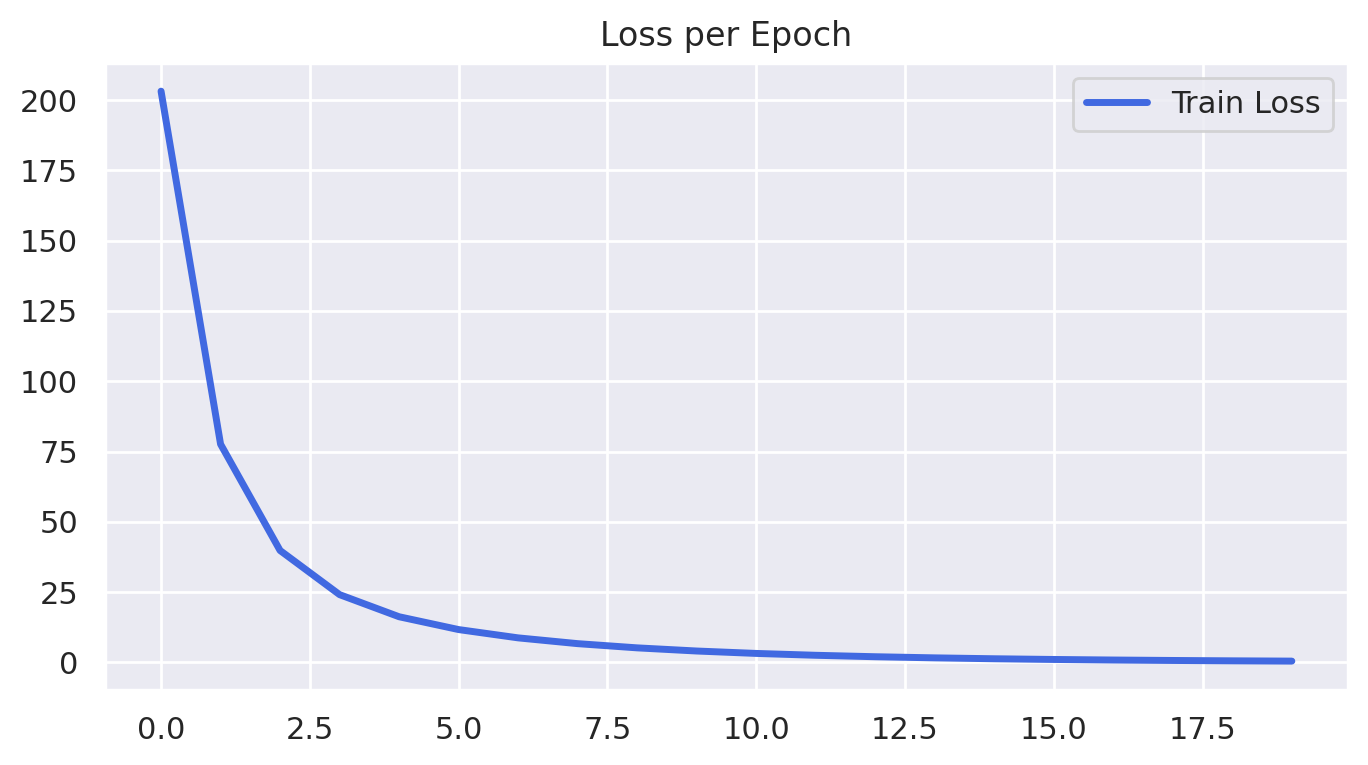

In [34]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")
sns.lineplot(x=range(len(costs)), y=[float(cost) for cost in costs], color='royalblue', label='Train Loss', linewidth=2.5)
plt.title("Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
y_pred = forwards(X, layers)

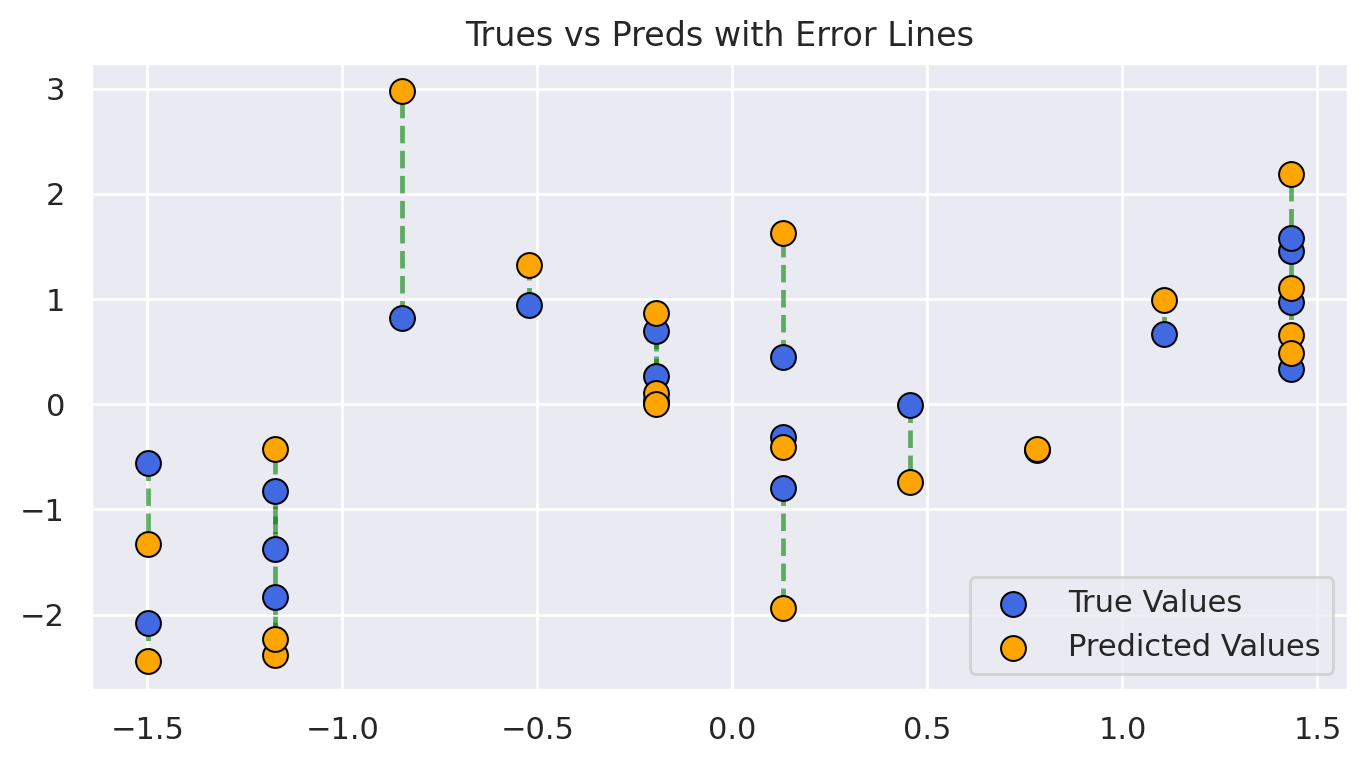

In [36]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")

for x_point, y_point, pred_point in zip(X[:, 0], y.reshape(-1), y_pred.reshape(-1)):
  plt.plot([x_point, x_point], [y_point, pred_point], color='green', linestyle='--', linewidth=1.7, alpha=0.6, zorder=1)

sns.scatterplot(x=X[:, 0], y=y.reshape(-1), s=80, color='royalblue', edgecolor='black', label='True Values', zorder=2)
sns.scatterplot(x=X[:, 0], y=y_pred.reshape(-1), s=80, color='orange', edgecolor='black', label='Predicted Values', zorder=2)

plt.title("Trues vs Preds with Error Lines")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
X_range = np.linspace(start=-1.5, stop=1.5, num=300).reshape(100, 3)
y_hat_range = forwards(X_range, layers)

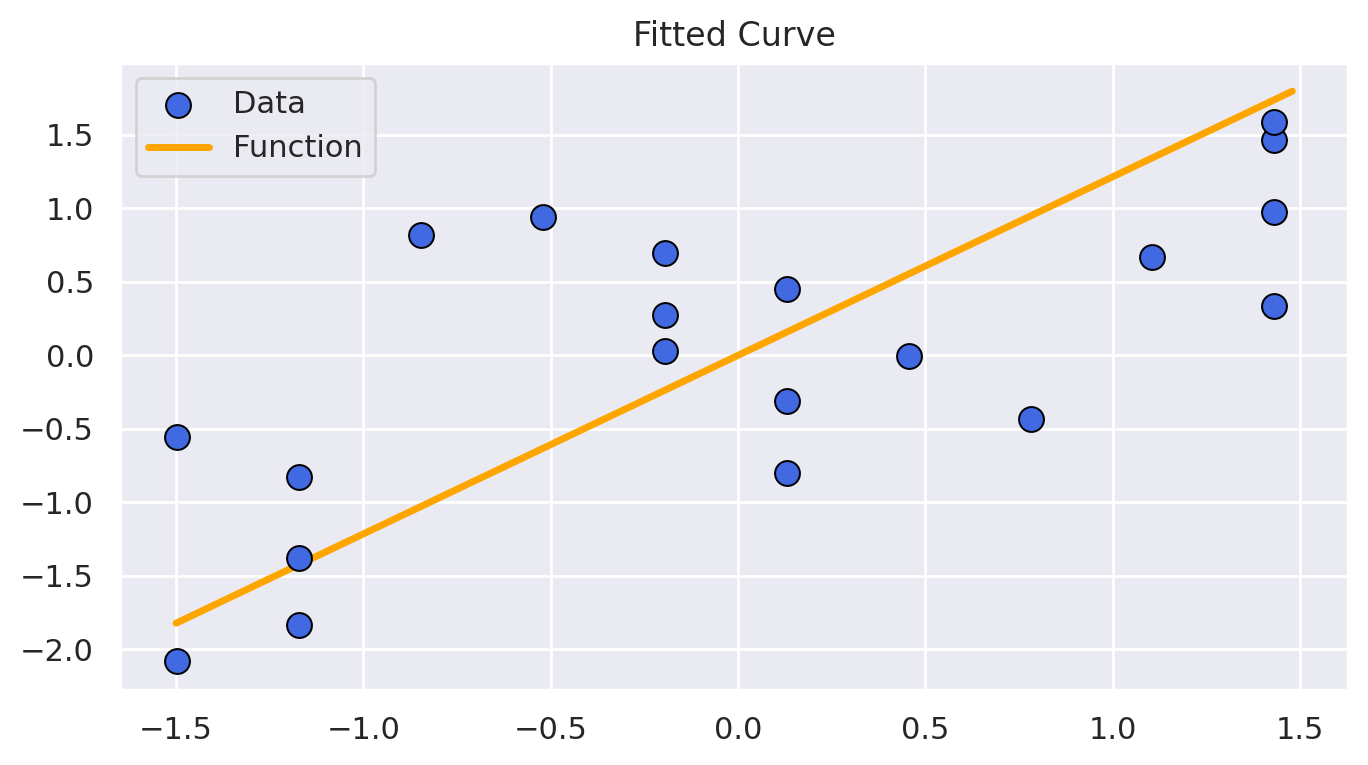

In [38]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")


sns.scatterplot(x=X[:, 0], y=y.reshape(-1), s=80, color='royalblue', edgecolor='black', label='Data', zorder=2)
sns.lineplot(x=X_range[:, 0], y=y_hat_range.reshape(-1), color='orange', label='Function', zorder=1, linewidth=2.5)

plt.title("Fitted Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Define Model Class
every thing in one place: (model build function, fit function and more)


In [187]:
class Model:
  def __init__(self, layers: list[DenseLayer]):
      self.layers = layers

  def fit(self, X, target, lr=1e-04, epochs=20):
      self.X = X
      self.target = target

      history = gradient_descent(X, self.target, self.layers, lr, epochs)
      self.history = history
      return self.history

  def predict(self, X):
      A = X
      for layer in self.layers:
          A = layer.propagate(A)
      return A

## Train and Test Model from Scratch on New Data

In [93]:
X_set, y_set = dummy_data(25, 3)
X_set = z_score_normalization(X_set)
y_set = z_score_normalization(y_set)

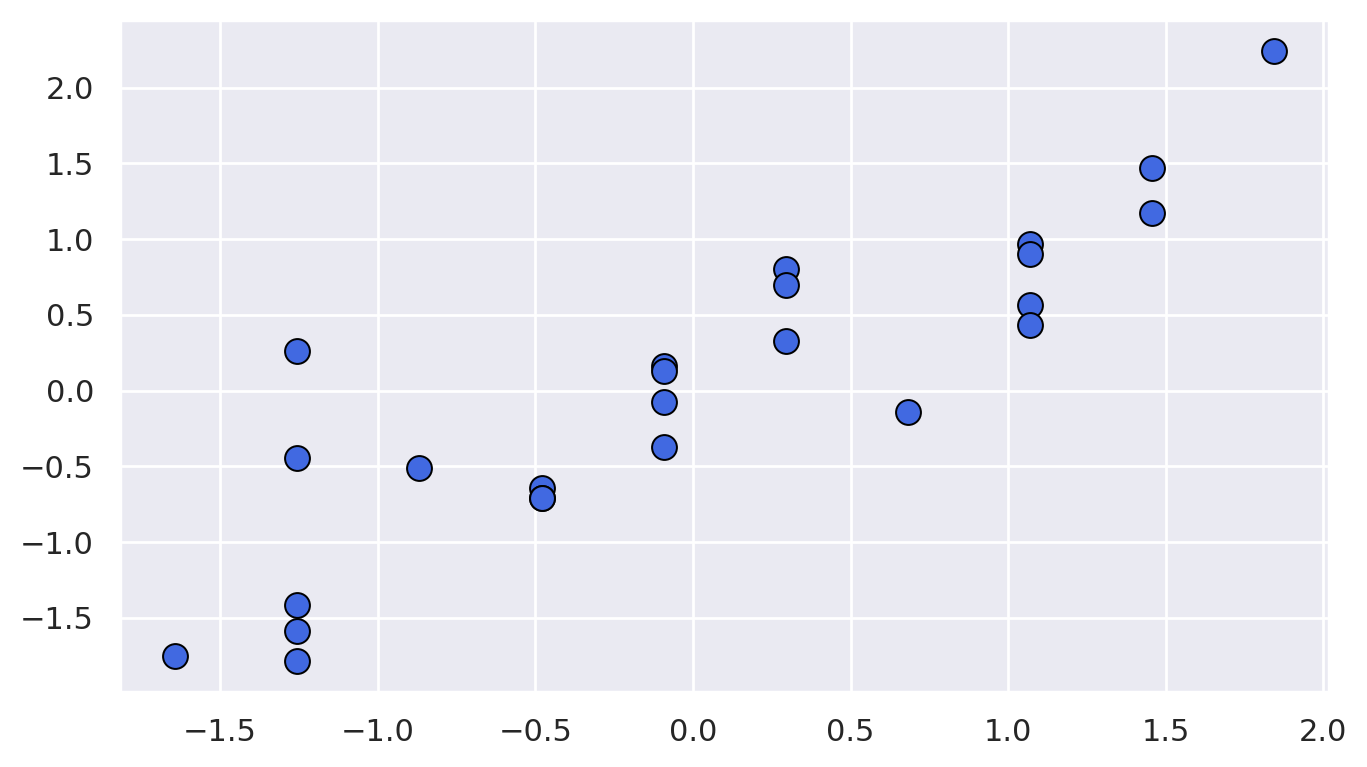

In [94]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")

sns.scatterplot(x=X_set[:, 0], y=y_set.reshape(-1), s=80, color='royalblue', edgecolor='black')

plt.tight_layout()
plt.show()

In [112]:
# train test split
train_split_precetage = 0.8
end_train = int(train_split_precetage * len(X_set))

X_train = X_set[:end_train]
y_train = y_set[:end_train]

X_test = X_set[end_train:]
y_test = y_set[end_train:]

In [113]:
model = Model([
    DenseLayer(10),
    DenseLayer(5),
    DenseLayer(1)
])

In [114]:
history = model.fit(X_train, y_train, lr=1e-03, epochs=25)

epoch 1, train_loss=188.51202491383373
epoch 4, train_loss=21.58300107628807
epoch 7, train_loss=4.682120730650515
epoch 10, train_loss=1.8204518917456416
epoch 13, train_loss=1.2085103765348966
epoch 16, train_loss=1.0096423466690656
epoch 19, train_loss=0.9062834891554493
epoch 22, train_loss=0.8357560701552067
epoch 25, train_loss=0.781682428992162


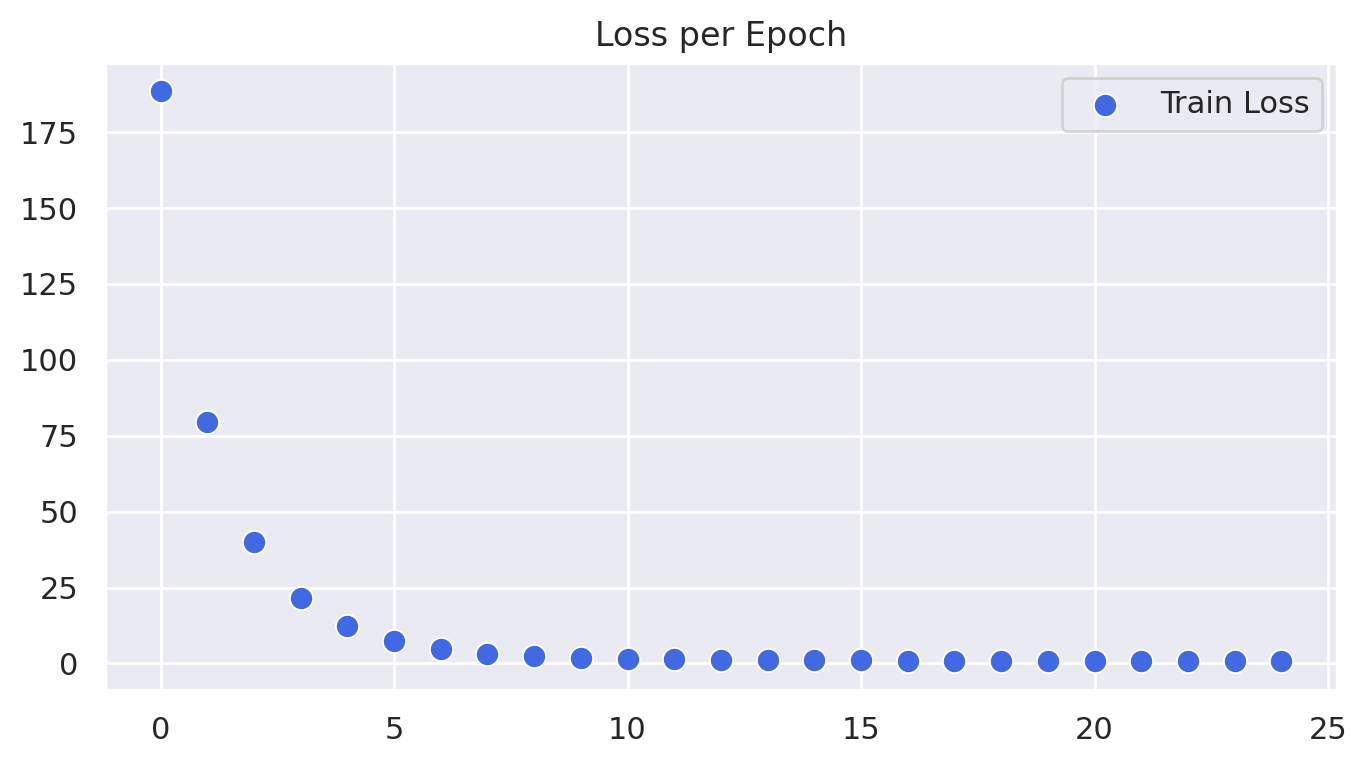

In [130]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")
sns.scatterplot(x=range(len(history)), y=[float(cost) for cost in history], color='royalblue', label='Train Loss', s=70)
plt.title("Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [115]:
test_pred = model.predict(X_test)

In [118]:
test_loss = float(mean_squared_error(y_test, test_pred))
print(f'Train Loss: {history[-1]} | Test Loss {test_loss}')

Train Loss: 0.781682428992162 | Test Loss 1.1942682050451423


# Multy Feature Housing Price Prediction

In [133]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [201]:
data, traget = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, traget.reshape(-1, 1), test_size=0.25, random_state=42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (15480, 8), y_train: (15480, 1)
X_test: (5160, 8), y_test: (5160, 1)


In [202]:
mini_X_train, mini_X_test, mini_y_train, mini_y_test = X_train[:1500], X_test[:500], y_train[:1500], y_test[:500]

print(f"X_train: {mini_X_train.shape}, y_train: {mini_y_train.shape}")
print(f"X_test: {mini_X_test.shape}, y_test: {mini_y_test.shape}")

X_train: (1500, 8), y_train: (1500, 1)
X_test: (500, 8), y_test: (500, 1)


In [203]:
mini_X_train = z_score_normalization(mini_X_train)
mini_X_test = z_score_normalization(mini_X_test)
mini_y_train = z_score_normalization(mini_y_train)
mini_y_test = z_score_normalization(mini_y_test)

In [212]:
house_price_model = Model([
    DenseLayer(10),
    DenseLayer(4),
    DenseLayer(1),
])

house_model_history = house_price_model.fit(mini_X_train, mini_y_train, lr=1e-03, epochs=25)

epoch 1, train_loss=102.70630734207963
epoch 4, train_loss=28.57543386217234
epoch 7, train_loss=11.537905821763086
epoch 10, train_loss=5.458451127462969
epoch 13, train_loss=2.9343475622126474
epoch 16, train_loss=1.8120137066570126
epoch 19, train_loss=1.2923724255581173
epoch 22, train_loss=1.042840423169054
epoch 25, train_loss=0.9170862353902651


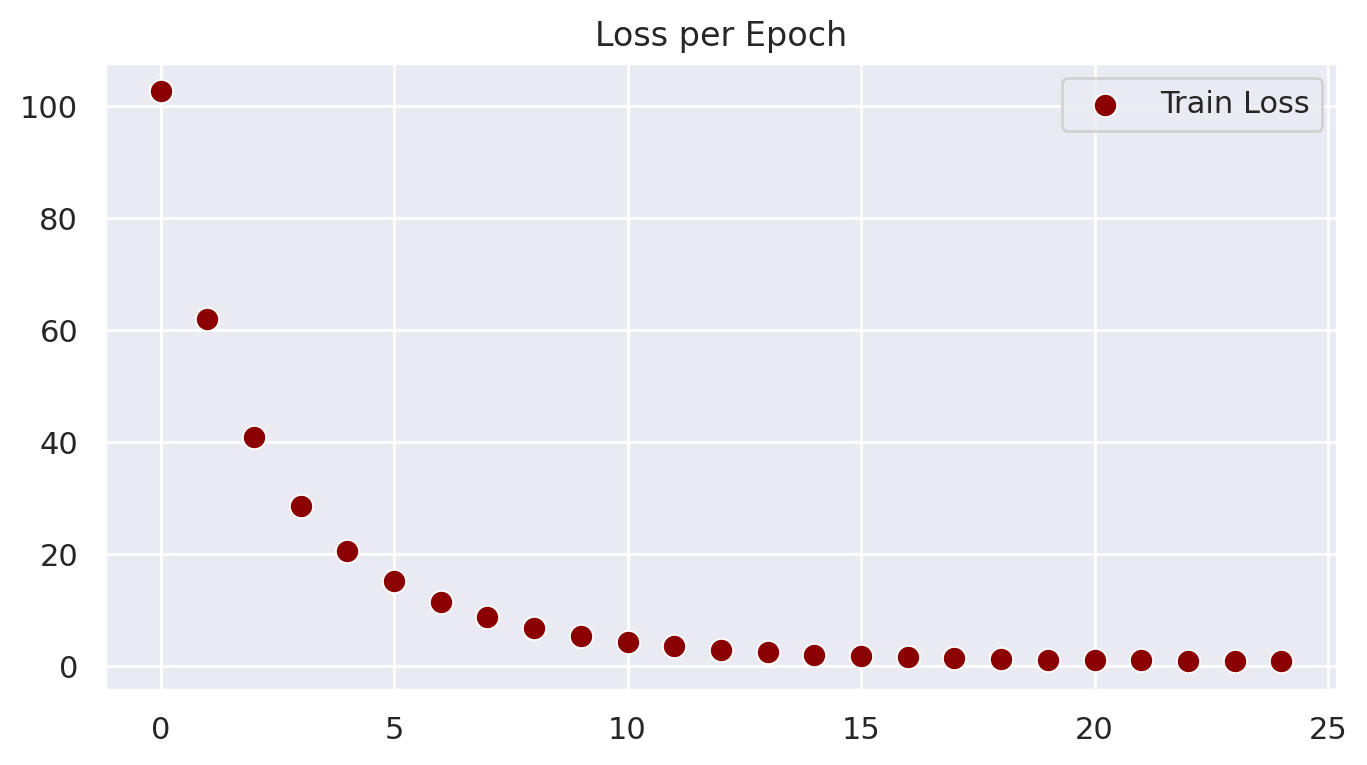

In [217]:
fig = plt.figure(figsize=(7, 4))
sns.set(style="darkgrid", context="notebook")
sns.scatterplot(x=range(len(house_model_history)), y=[float(cost) for cost in house_model_history], color='darkred', label='Train Loss', s=70)
plt.title("Loss per Epoch")
plt.legend()
plt.tight_layout()
plt.show()

In [218]:
test_pred = house_price_model.predict(mini_X_test)
test_loss = float(mean_squared_error(mini_y_test, test_pred))
print(f'Train Loss: {house_model_history[-1]} | Test Loss {test_loss}')

Train Loss: 0.9170862353902651 | Test Loss 0.8527291626215235
